In [9]:
from igraph import *
import random

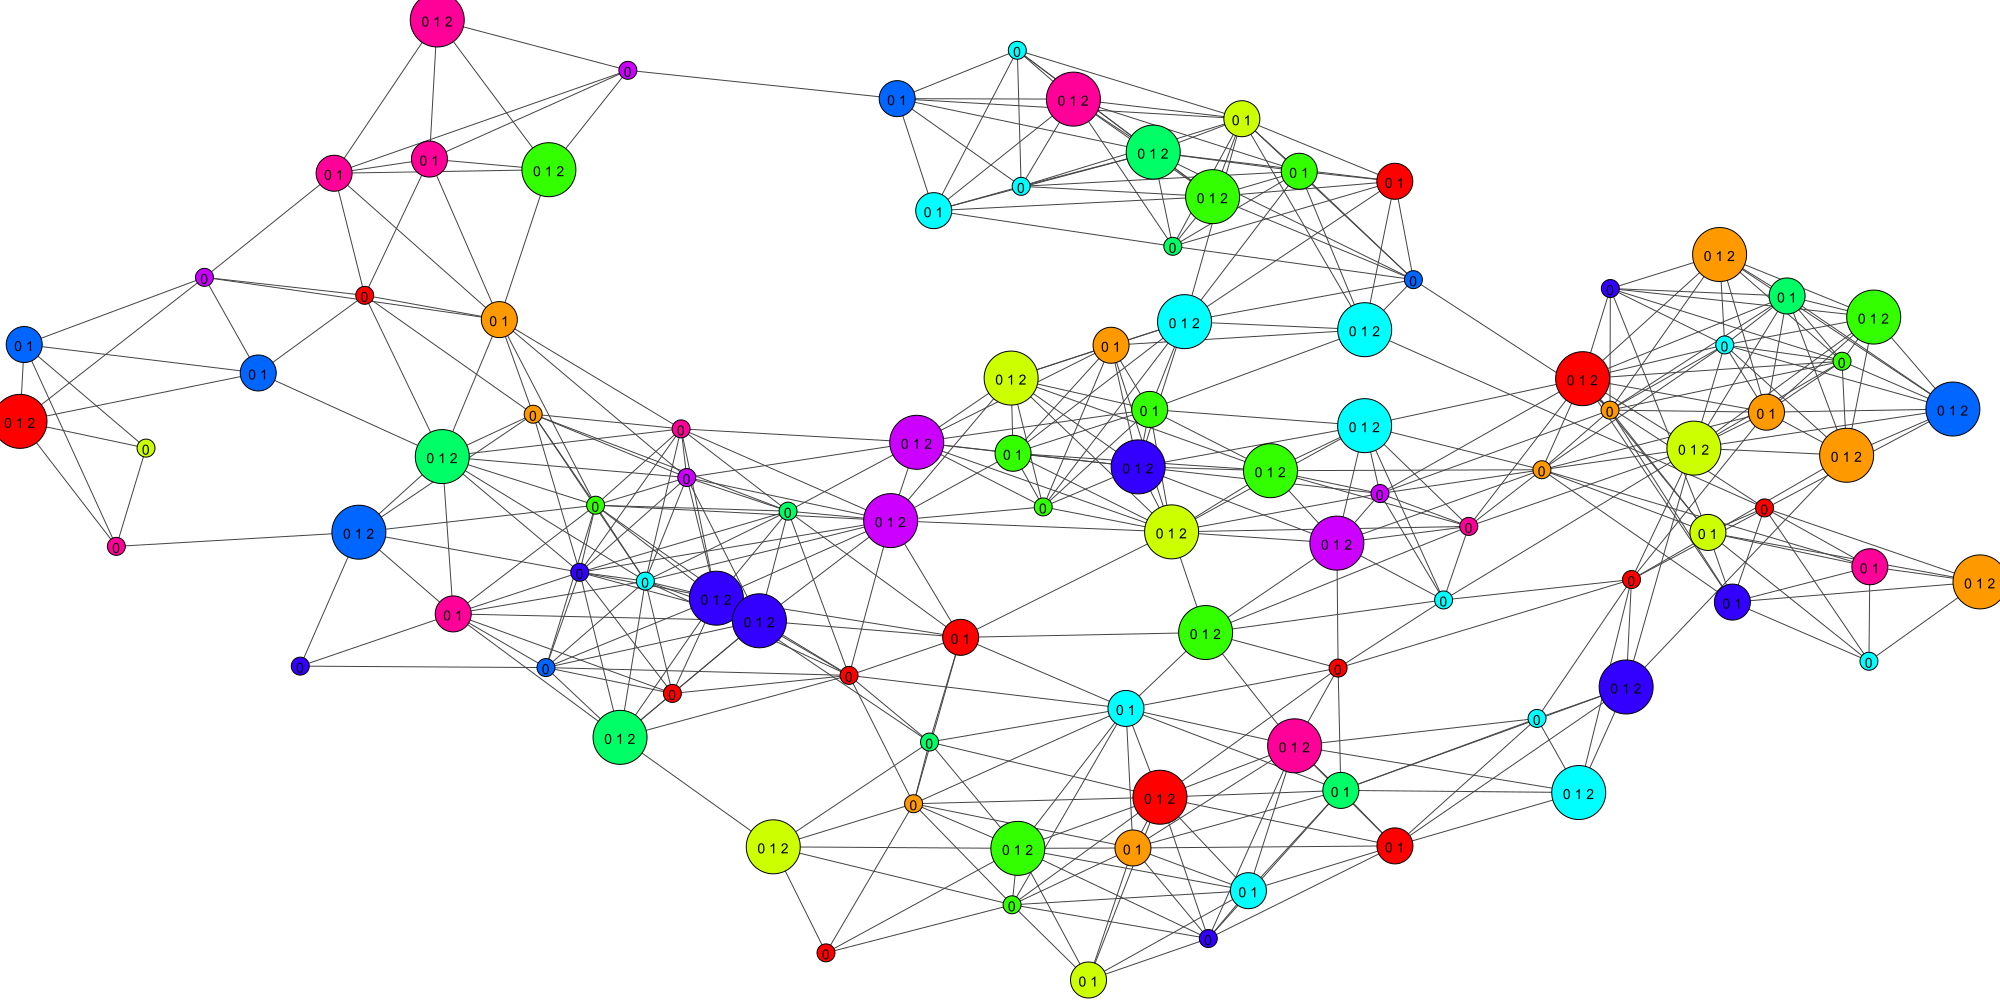

In [29]:
g = Graph.GRG(100, 0.2)

communitiesCount = 10
colors = RainbowPalette(communitiesCount)

for v in g.vs:
    v["community"] = random.randint(0, communitiesCount - 1)
    
#map communities to colors
for v in g.vs:
    v["color"] = colors.get(v["community"])
    
    multipleCount = random.randint(1, 3)
    label = ""
    for i in range(multipleCount):
        label += str(i) + " "
        
    v["label"] = label
    v["size"] = multipleCount * 18
    
layout = g.layout("lgl")
visual_style = {}
visual_style["layout"] = layout
visual_style["bbox"] = (2000, 1000)
visual_style["margin"] = 20
plot(g, **visual_style)